In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT-24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt
import sys
sys.path.append('./utils')
from trading_functions import *
# Core Libraries
import os
import sys
import time
import datetime
import warnings
import itertools
import random
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


In [113]:
# Define constants
SEED = 1
history_length = [1, 2, 4, 5, 6, 8, 10, 16, 20]
history_length.reverse()
reward_type = 'LNR'
start_date = '2023-07-01'
end_date = '2024-12-02'
n_envs = 8
n_steps = 16
total_timesteps = 10_000
batch_size = 32
learning_rate = 0.0001
ent_coef = 0.05
log_interval = 1_000
eval_freq = 1_000
model_name= 'A2C'

In [134]:
# Example stock list
stock_list = ['AAPL', 'ABBV', 'ADBE', 'AES', 'AMAT', 'AMCR', 'AMD', 'AMZN', 'ANET', 'APA', 'APH', 'AVGO', 'BA', 'BAC', 'BMY', 'C', 'CCI', 'CCL', 'CMCSA', 'CMG', 'CNP', 'COP', 'CRM', 'CSCO', 'CSX', 'CTRA', 'CVS', 'CVX', 'DAL', 'DIS', 'DVN', 'EQT', 'EW', 'EXC', 'F', 'FCX', 'GE', 'GILD', 'GIS', 'GM', 'GOOG', 'GOOGL', 'HAL', 'HBAN', 'HPQ', 'HST', 'INTC', 'IPG', 'JNJ', 'JPM', 'KDP', 'KEY', 'KMI', 'KO', 'LRCX', 'LUV', 'MCHP', 'MDLZ', 'MDT', 'META', 'MO', 'MRK', 'MS', 'MSFT', 'MU', 'NCLH', 'NEE', 'NEM', 'NKE', 'NVDA', 'ON', 'ORCL', 'OXY', 'PARA', 'PCG', 'PEP', 'PFE', 'PG', 'QCOM', 'RF', 'SBUX', 'SCHW', 'SLB', 'SMCI', 'T', 'TFC', 'TJX', 'TSLA', 'UNH', 'USB', 'V', 'VTRS', 'VZ', 'WBA', 'WBD', 'WDC', 'WFC', 'WMB', 'WMT', 'XOM']

# Initialize combined sectors
combined_sectors = {
    "Tech": [],
    "Consumer Goods (Cyclical & Defensive)": [],
    "Healthcare & Utilities": [],
    "Energy & Basic Materials": [],
    "Financial Services & Real Estate": [],
    "Industrials": [],
}

# Mapping sectors to combined groups
sector_to_group = {
    "Technology": "Tech",
    "Communication Services": "Industrials",
    "Consumer Cyclical": "Consumer Goods (Cyclical & Defensive)",
    "Consumer Defensive": "Consumer Goods (Cyclical & Defensive)",
    "Healthcare": "Healthcare & Utilities",
    "Utilities": "Healthcare & Utilities",
    "Energy": "Energy & Basic Materials",
    "Basic Materials": "Energy & Basic Materials",
    "Financial Services": "Financial Services & Real Estate",
    "Real Estate": "Financial Services & Real Estate",
    "Industrials": "Industrials",
}

# Fetch sector, volume, and assign tickers to groups
volume_data = []

for ticker in stock_list:
    stock = yf.Ticker(ticker)
    info = stock.info
    sector = info.get('sector')
    if sector in sector_to_group:
        group = sector_to_group[sector]
        volume = info.get('volume', 0)  # Fetch trading volume
        volume_data.append((ticker, group, volume))

# Sort and filter top 14 stocks by volume for each sector group
for group in combined_sectors.keys():
    top_stocks = sorted(
        [t for t in volume_data if t[1] == group], key=lambda x: x[2], reverse=True
    )[:14]
    combined_sectors[group] = [t[0] for t in top_stocks]

# Function to create groups, picking the highest-volume stock remaining
def create_stock_groups(sector_data, group_size=6):
    groups = []
    while True:
        current_group = []
        for sector, tickers in list(sector_data.items()):
            if tickers:  # Ensure tickers are available
                selected_stock = tickers.pop(0)  # Select the highest-volume stock
                current_group.append(selected_stock)
            if len(current_group) == group_size:
                break
        
        if len(current_group) == group_size:
            groups.append(current_group)
        else:
            break  # Stop if a complete group can't be formed

    return groups

# Generate groups
groups = create_stock_groups(combined_sectors)

# Print the groups
for i, group in enumerate(groups, 1):
    print(f"Group {i}: {group}")

# Print remaining tickers in each sector
print("\nRemaining Tickers by Sector:")
for group, tickers in combined_sectors.items():
    print(f"{group}: {tickers}")


Group 1: ['NVDA', 'TSLA', 'PFE', 'XOM', 'BAC', 'VZ']
Group 2: ['SMCI', 'F', 'WBA', 'DVN', 'C', 'GOOGL']
Group 3: ['INTC', 'AMZN', 'CVS', 'OXY', 'HBAN', 'T']
Group 4: ['AMD', 'CCL', 'PCG', 'KMI', 'WFC', 'WBD']
Group 5: ['AVGO', 'WMT', 'VTRS', 'SLB', 'KEY', 'CMCSA']
Group 6: ['AAPL', 'MDLZ', 'AES', 'HAL', 'JPM', 'GOOG']
Group 7: ['MU', 'MO', 'BMY', 'FCX', 'MS', 'CSX']
Group 8: ['CSCO', 'SBUX', 'MRK', 'CVX', 'V', 'META']
Group 9: ['MSFT', 'KO', 'JNJ', 'NEM', 'RF', 'BA']
Group 10: ['LRCX', 'NKE', 'NEE', 'CTRA', 'USB', 'PARA']
Group 11: ['MCHP', 'GM', 'ABBV', 'COP', 'SCHW', 'DAL']
Group 12: ['ON', 'AMCR', 'MDT', 'APA', 'TFC', 'LUV']
Group 13: ['QCOM', 'NCLH', 'GILD', 'WMB', 'HST', 'GE']
Group 14: ['AMAT', 'PEP', 'EXC', 'EQT', 'CCI', 'DIS']

Remaining Tickers by Sector:
Tech: []
Consumer Goods (Cyclical & Defensive): []
Healthcare & Utilities: []
Energy & Basic Materials: []
Financial Services & Real Estate: []
Industrials: []


Stage 1: Set time intervals

In [4]:
rep = 0
while rep < 4:
    rep += 1
    print('Try',rep)
    try:
        # Training environment
        stocks = random.sample(technology_tickers, 6)
        print(stocks)
        env = create_training_env(history_length[0], reward_type, start_date, end_date, stocks, 1)[0]
        break
    except:
        print('Error')
        time.sleep(1)

Try 1
['SMCI', 'MSFT', 'ORCL', 'INTC', 'AAPL', 'AVGO']


Stage 1: Multiple stock learning

In [5]:
envs=[]
models = []
for h in range(9):
    envs.append(create_training_env(history_length[h], reward_type, start_date, end_date, stocks, 1)[0])
    for i in range(6):
        model_save_dir = f'./models/history_length/{history_length[h]}/{i}'
        models.append(A2C.load(model_save_dir,envs[h]))
    model_save_dir = f'./models/history_length/{history_length[h]}/best_model'
    models.append(A2C.load(model_save_dir,envs[h]))
from collections import Counter

In [6]:
env = envs[0]

Total return of portfolio: -99.19%
Total reward: -9.829191555473724


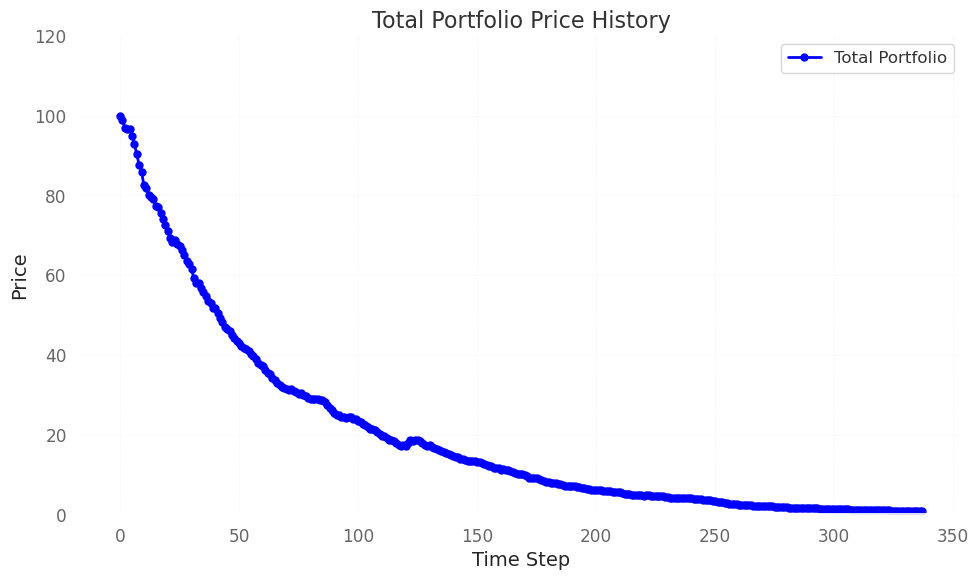

In [7]:
observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    # Get actions from models
    action = env.action_space.sample()
    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')

[5, 1, 5, 5, 5, 1, 4, 1, 5] 5
[5, 5, 5, 1, 5, 0, 5, 5, 5] 5
[5, 1, 5, 6, 5, 0, 5, 5, 5] 5
[5, 1, 5, 1, 5, 6, 5, 1, 5] 5
[5, 1, 5, 6, 5, 6, 4, 1, 5] 5
[6, 1, 5, 1, 4, 4, 4, 1, 5] 1
[6, 1, 5, 6, 5, 4, 5, 5, 5] 5
[6, 1, 4, 6, 4, 4, 4, 1, 5] 4
[6, 6, 5, 6, 4, 4, 4, 1, 5] 6
[6, 6, 5, 4, 4, 4, 4, 1, 5] 4
[6, 1, 5, 4, 4, 5, 4, 1, 5] 5
[6, 6, 4, 4, 4, 5, 4, 1, 5] 4
[6, 1, 0, 4, 4, 4, 4, 1, 5] 4
[6, 6, 4, 4, 4, 4, 4, 4, 5] 4
[6, 6, 0, 4, 4, 4, 4, 4, 5] 4
[6, 6, 4, 4, 4, 5, 4, 1, 5] 4
[6, 2, 4, 4, 4, 5, 4, 1, 5] 4
[6, 6, 0, 4, 4, 4, 4, 1, 5] 4
[6, 3, 0, 4, 4, 5, 4, 5, 5] 4
[6, 3, 0, 4, 4, 5, 4, 1, 5] 4
[0, 3, 0, 4, 4, 5, 4, 2, 5] 4
[0, 3, 0, 4, 5, 5, 4, 2, 5] 5
[0, 2, 0, 4, 5, 5, 4, 2, 5] 5
[0, 2, 0, 2, 4, 5, 4, 2, 5] 2
[0, 2, 0, 2, 5, 5, 4, 5, 5] 5
[0, 5, 0, 4, 5, 5, 5, 2, 5] 5
[0, 5, 0, 2, 2, 5, 5, 2, 5] 5
[0, 5, 0, 2, 5, 5, 5, 2, 5] 5
[0, 5, 0, 4, 5, 5, 4, 2, 5] 5
[0, 5, 2, 4, 5, 5, 4, 2, 5] 5
[0, 5, 5, 4, 5, 5, 4, 2, 5] 5
[0, 1, 2, 4, 5, 5, 5, 2, 5] 5
[6, 1, 2, 4, 4, 5, 4, 2, 5] 4
[6, 1, 2, 

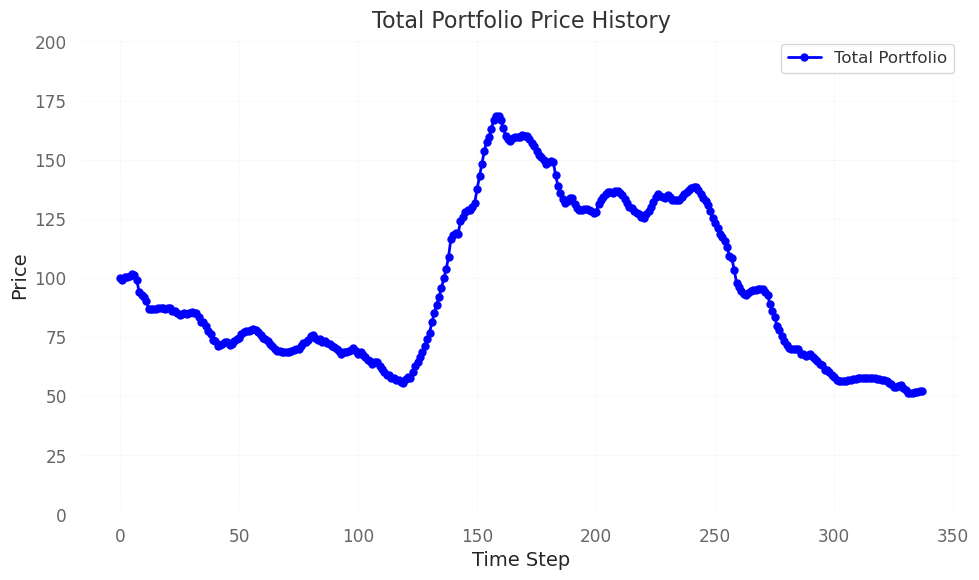

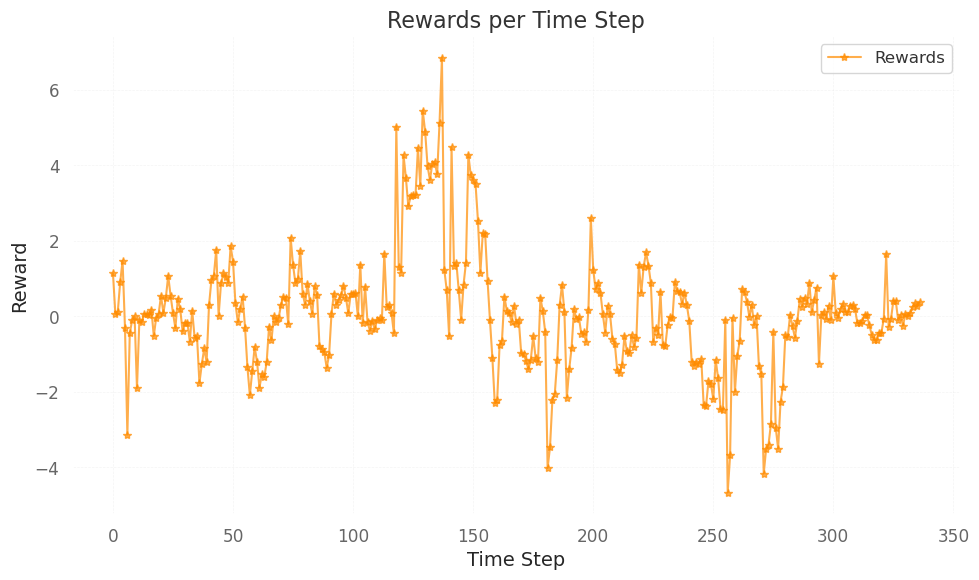

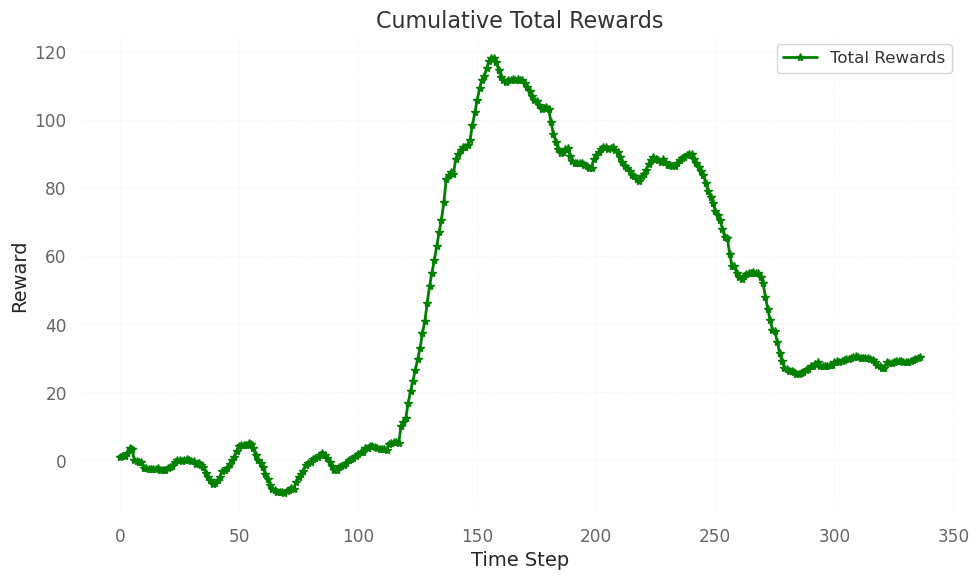

Total rewards: 30.33254783796861


In [8]:
# Initialize the environment and variables

observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    for h in range(9):
        # Get actions from models
        if has_policy:
            for i in range(5,6):
                actions.append(int(models[7*h+i].policy.predict(observation[-(envs[h].ColSize*envs[h].num_stocks*envs[h].history_length):], deterministic=True)[0]))
        else:
            for i in range(5,6):
                actions.append(int(models[7*h+i].predict(observation[-(envs[h].ColSize*envs[h].num_stocks*envs[h].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')
env.render('rewards')
     
#env.close()
#del env 

[1, 1, 0, 0, 5, 5, 0, 1, 0, 1, 5, 1, 2, 2, 2, 5, 5, 5, 0, 0, 2, 1, 5, 5, 1, 1, 4, 3, 5, 5, 1, 2, 2, 1, 1, 1, 1, 4, 4, 4, 5, 4, 0, 1, 4, 5, 5, 1, 2, 0, 4, 5, 5, 5] 5
[4, 1, 0, 0, 5, 5, 4, 4, 0, 4, 5, 5, 2, 4, 4, 0, 0, 5, 0, 1, 2, 1, 5, 1, 1, 1, 4, 3, 5, 5, 1, 2, 2, 1, 6, 0, 1, 4, 4, 3, 5, 5, 0, 1, 4, 5, 5, 5, 2, 0, 4, 5, 5, 5] 5
[1, 1, 3, 0, 5, 5, 0, 4, 0, 0, 5, 1, 2, 4, 4, 5, 5, 5, 0, 1, 4, 6, 6, 6, 1, 1, 4, 3, 5, 5, 1, 2, 2, 1, 1, 0, 1, 4, 4, 3, 5, 5, 0, 1, 4, 5, 5, 5, 2, 0, 4, 5, 5, 5] 5
[1, 1, 0, 0, 5, 5, 5, 4, 0, 3, 5, 1, 2, 4, 4, 2, 5, 5, 0, 1, 4, 4, 5, 1, 1, 1, 4, 3, 5, 5, 1, 2, 2, 1, 6, 6, 1, 4, 4, 3, 5, 5, 0, 1, 4, 5, 5, 1, 2, 4, 4, 5, 5, 5] 5
[1, 1, 3, 0, 5, 5, 5, 4, 4, 4, 5, 1, 2, 4, 2, 1, 5, 5, 0, 1, 4, 4, 6, 6, 1, 1, 4, 3, 5, 5, 2, 2, 4, 4, 6, 6, 1, 4, 4, 3, 3, 4, 0, 1, 4, 5, 5, 1, 4, 4, 4, 4, 5, 5] 4
[1, 1, 3, 3, 5, 6, 5, 5, 4, 4, 5, 1, 4, 4, 2, 2, 5, 5, 0, 1, 4, 4, 5, 1, 1, 1, 4, 4, 5, 4, 1, 2, 4, 4, 6, 4, 1, 4, 4, 3, 3, 4, 3, 1, 4, 4, 5, 1, 4, 4, 4, 5, 5, 5] 4
[1, 1, 3, 

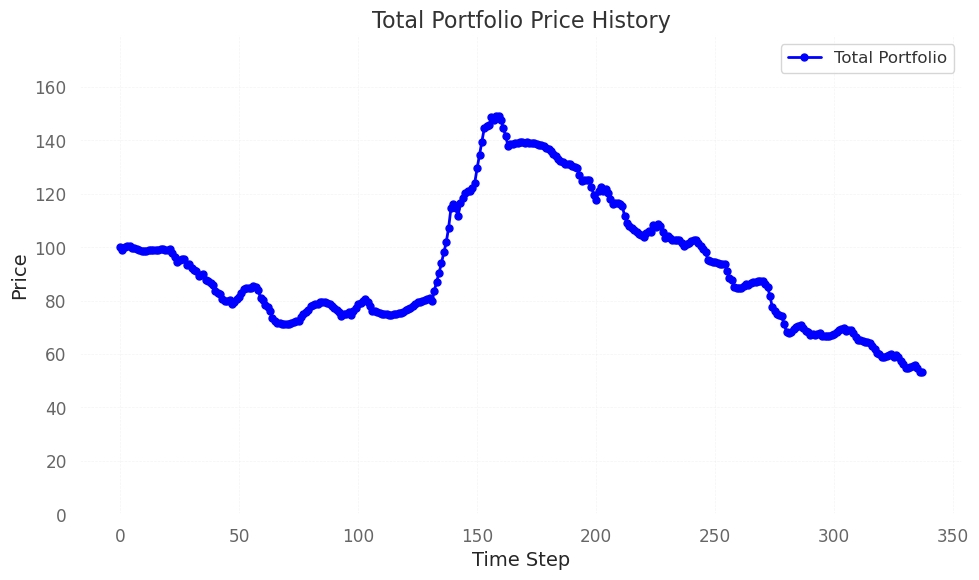

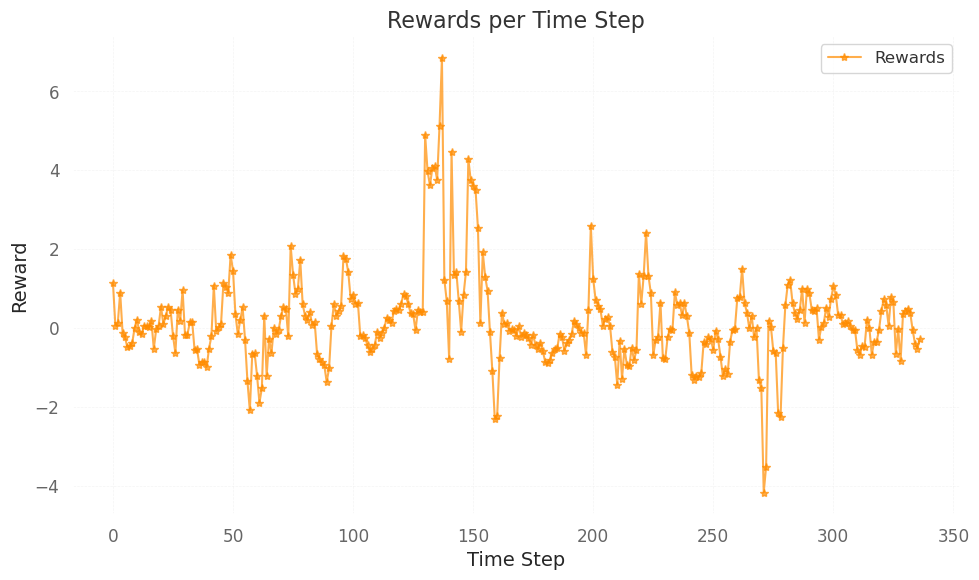

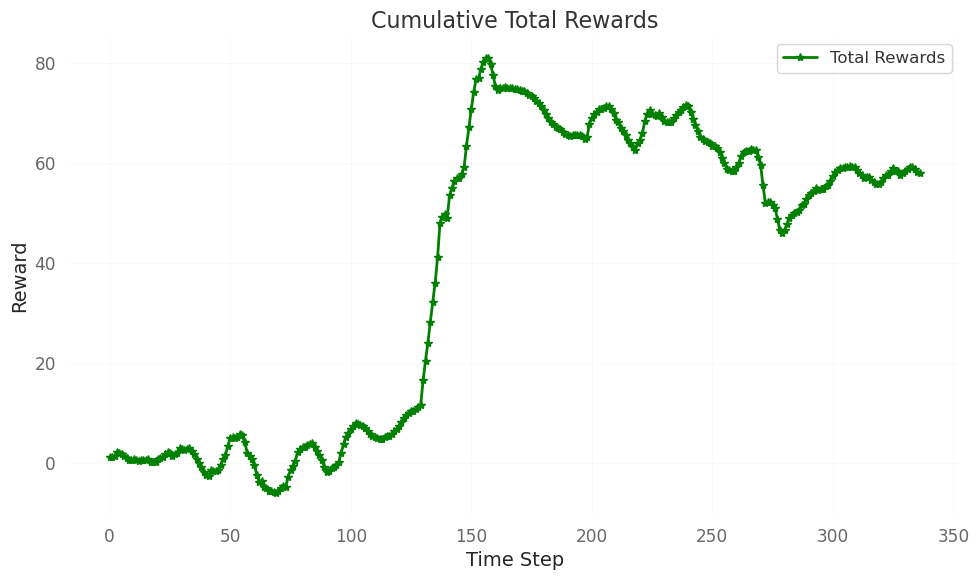

Total rewards: 57.97444864240901


In [9]:
# Initialize the environment and variables

observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    for h in range(9):
        # Get actions from models
        if has_policy:
            for i in range(6):
                actions.append(int(models[7*h+i].policy.predict(observation[-(envs[h].ColSize*envs[h].num_stocks*envs[h].history_length):], deterministic=True)[0]))
        else:
            for i in range(6):
                actions.append(int(models[7*h+i].predict(observation[-(envs[h].ColSize*envs[h].num_stocks*envs[h].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')
env.render('rewards')
     
#env.close()
#del env 

Total return of portfolio: -67.69%
Total reward: 14.918702821448289


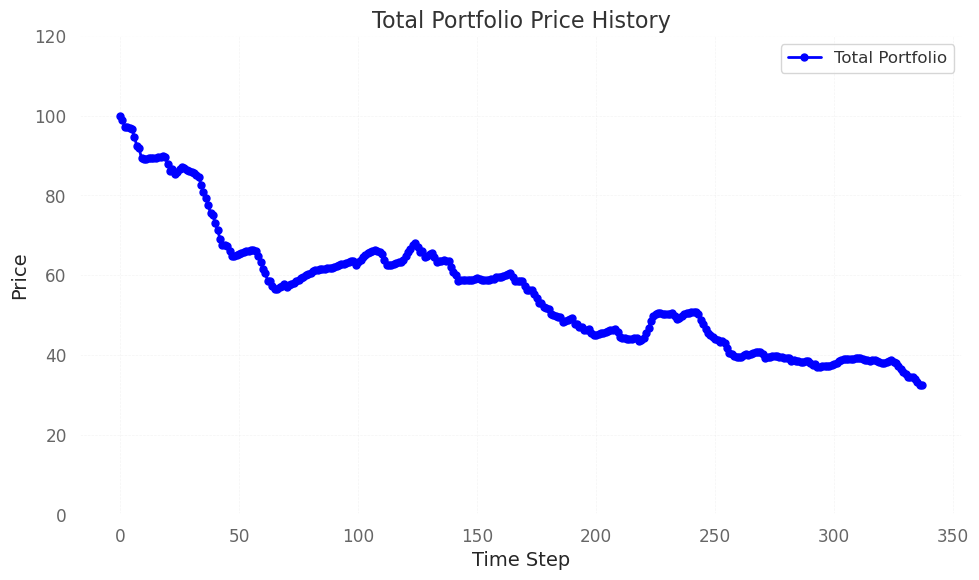

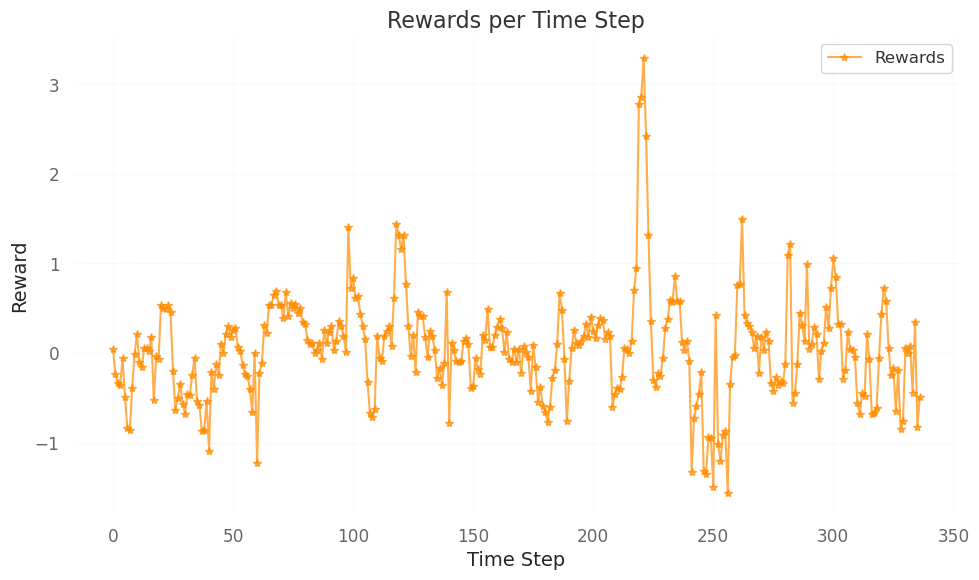

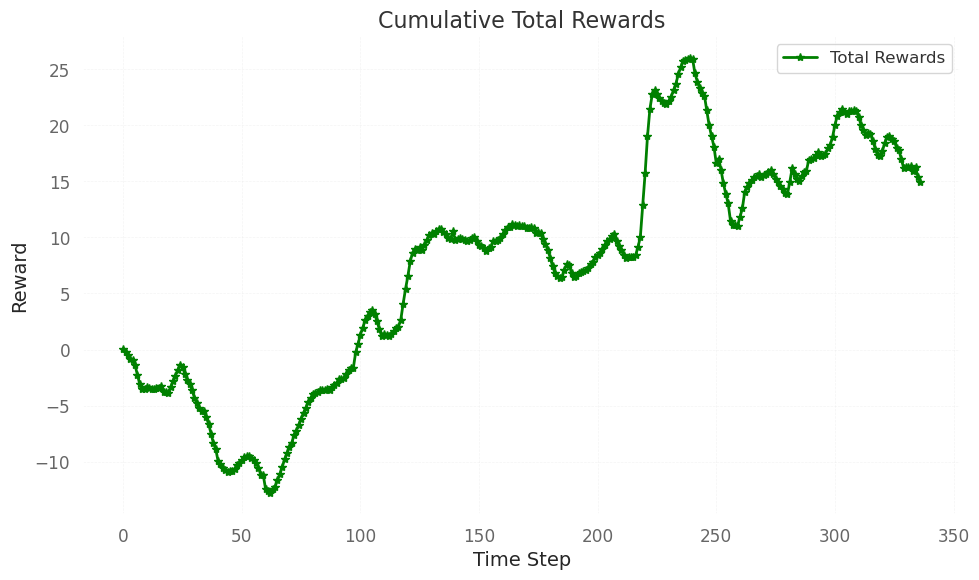

Total rewards: 14.918702821448289


In [10]:
# Initialize the environment and variables
#for i in range(7):

observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    # Get actions from models
    if has_policy:
        for i in range(9):
            actions.append(int(models[6+7*i].policy.predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))
    else:
        for i in range(9):
            actions.append(int(models[6+7*i].predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    #print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')
env.render('rewards')
     
env.close()
del env 

In [11]:
stocks

['SMCI', 'MSFT', 'ORCL', 'INTC', 'AAPL', 'AVGO']